### Pairs Trading

In [1]:
# make the necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
idx = pd.IndexSlice
import statsmodels.api as sm

from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Stock Universe and Identification of Cointegrated Pairs of Stocks

In [3]:
# read the matadata csv
nifty_meta = pd.read_csv('nifty_meta.csv')
nifty_meta.head(2)

,Company Name,Industry,Symbol,Series,ISIN Code
0,ACC Ltd.,CEMENT & CEMENT PRODUCTS,ACC,EQ,INE012A01025
1,Adani Ports and Special Economic Zone Ltd.,SERVICES,ADANIPORTS,EQ,INE742F01042


In [5]:
# get the ticker list with industry is equal to FINANCIAL SERVICES
tickers = list(nifty_meta[nifty_meta.Industry=='CONSUMER GOODS'].Symbol)
print(tickers)
print(len(tickers))

['ASIANPAINT', 'DMART', 'BERGEPAINT', 'BRITANNIA', 'COLPAL', 'DABUR', 'GODREJCP', 'HAVELLS', 'HINDUNILVR', 'ITC', 'MARICO', 'NESTLEIND', 'PGHH', 'TITAN', 'UBL', 'MCDOWELL-N']
16


In [11]:
# start and end dates for backtesting
fromdate = datetime.datetime(2010, 8, 1)
todate = datetime.datetime(2021, 6, 15)

In [ ]:
# # save the data as .csv file
# prices.to_csv('data/prices.csv')

In [12]:
# read back the pricing data
prices = pd.read_csv('prices-fmcg.csv', index_col=['ticker','date'], parse_dates=True)
prices.head(2)

open        high  ...   Adj Close     Volume
ticker     date                                ...                       
ASIANPAINT 2010-07-23  252.190002  254.800003  ...  230.266678   462690.0
           2010-07-26  251.699997  254.399994  ...  230.600098  1444310.0

[2 rows x 6 columns]

In [13]:
# remove tickers where we have less than 10 years of data.
min_obs = 2520
nobs = prices.groupby(level='ticker').size()
keep = nobs[nobs>min_obs].index

prices = prices.loc[idx[keep,:], :]
prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 35385 entries, ('ASIANPAINT', Timestamp('2010-07-23 00:00:00')) to ('UBL', Timestamp('2021-07-22 00:00:00'))
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       35289 non-null  float64
 1   high       35289 non-null  float64
 2   low        35289 non-null  float64
 3   close      35289 non-null  float64
 4   Adj Close  35289 non-null  float64
 5   Volume     35289 non-null  float64
dtypes: float64(6)
memory usage: 1.8+ MB


In [14]:
# final tickers list
TICKERS = list(prices.index.get_level_values('ticker').unique())
print(len(TICKERS))
print(TICKERS)

13
['ASIANPAINT', 'BERGEPAINT', 'BRITTANIA', 'COLPAL', 'DABUR', 'GODREJCP', 'HAVELLS', 'HINDUNILVR', 'MCDOWELL-N', 'NESTLEIND', 'PGHH', 'TITAN', 'UBL']


In [15]:
# unstack and take close price
close = prices.unstack('ticker')['close'].sort_index()
close = close.dropna()
close.head(2)

ticker,ASIANPAINT,BERGEPAINT,BRITTANIA,COLPAL,DABUR,GODREJCP,HAVELLS,HINDUNILVR,MCDOWELL-N,NESTLEIND,PGHH,TITAN,UBL
date,,,,,,,,,,,,,
2010-01-09,273.875000,32.303570,205.589996,413.274994,105.849998,126.699997,80.080002,266.549988,310.549988,3069.100098,2211.050049,19.200001,421.600006
2010-01-10,266.450012,39.392857,218.324997,443.200012,109.050003,136.916672,83.264999,309.700012,319.859985,3360.500000,2206.800049,24.299999,418.700012


In [16]:
# train test split 
train_close, test_close = train_test_split(close, test_size=0.5, shuffle=False)

In [17]:
# quick view of head and tail of train set
train_close.head(2).append(train_close.tail(2))

ticker,ASIANPAINT,BERGEPAINT,BRITTANIA,COLPAL,DABUR,GODREJCP,HAVELLS,HINDUNILVR,MCDOWELL-N,NESTLEIND,PGHH,TITAN,UBL
date,,,,,,,,,,,,,
2010-01-09,273.875000,32.303570,205.589996,413.274994,105.849998,126.699997,80.080002,266.549988,310.549988,3069.100098,2211.050049,19.200001,421.600006
2010-01-10,266.450012,39.392857,218.324997,443.200012,109.050003,136.916672,83.264999,309.700012,319.859985,3360.500000,2206.800049,24.299999,418.700012
2016-01-19,845.549988,178.857147,1366.500000,911.799988,249.550003,402.616669,284.399994,810.450012,546.229980,5428.799805,5311.750000,21.600000,840.950012
2016-01-20,840.349976,177.892853,1339.849976,913.299988,249.250000,395.933319,286.500000,795.049988,547.750000,5485.600098,5285.000000,21.600000,801.049988


Text(0.5, 1.0, 'Assets Correlation Matrix')

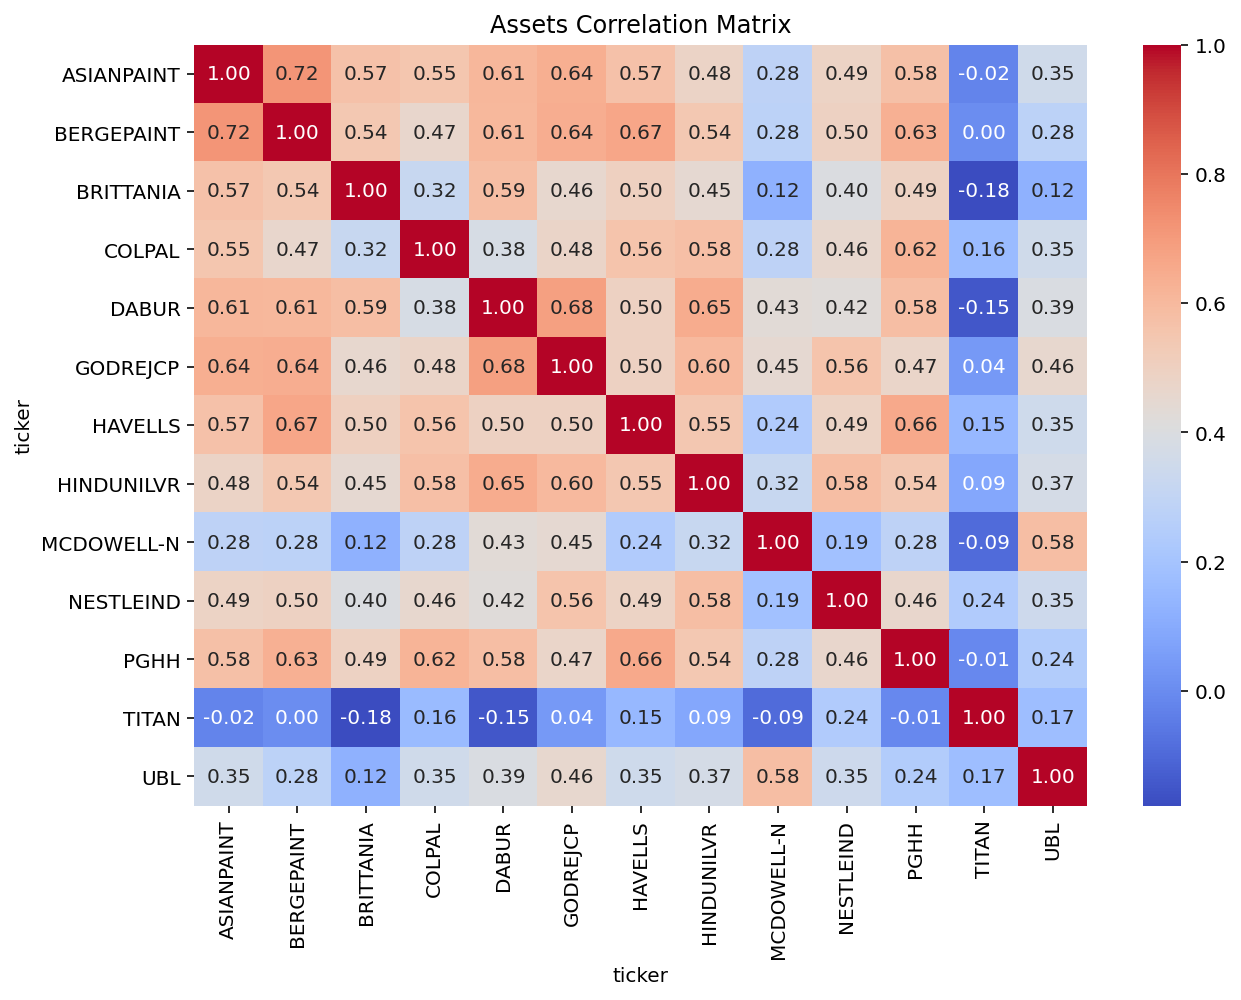

In [19]:
# Pearson correlation to get the basic idea about the relationship
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(train_close.pct_change().corr(method ='pearson'), ax=ax, cmap='coolwarm', annot=True, fmt=".2f") #spearman
ax.set_title('Assets Correlation Matrix')


In [20]:
# function to find cointegrated pairs
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.05:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

[('COLPAL', 'HINDUNILVR')]


FileNotFoundError: ignored

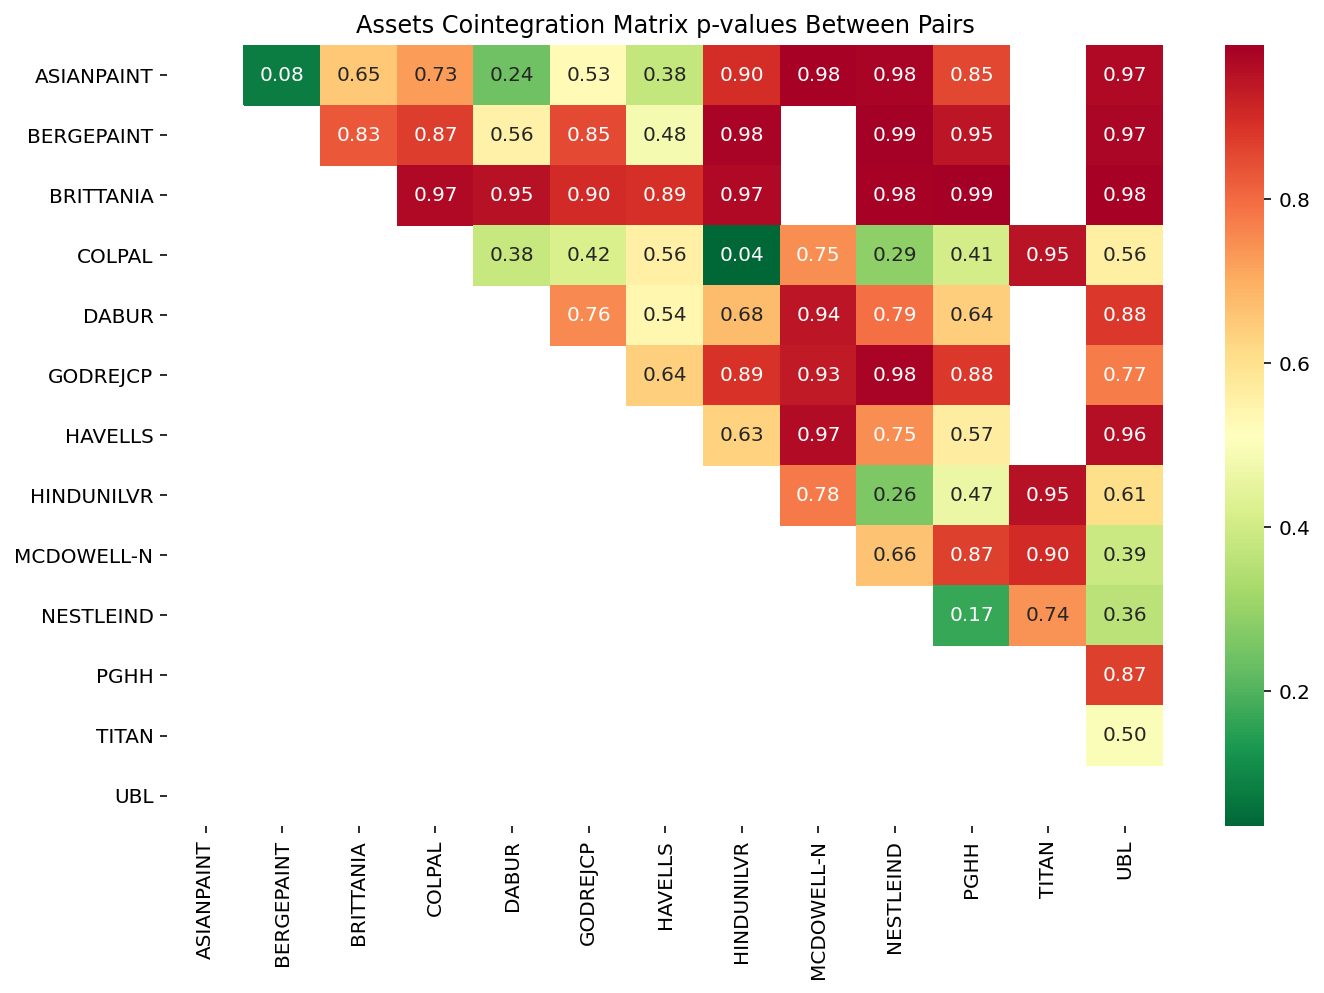

In [21]:
# calculate p-values and plot as a heatmap
pvalues, pairs = find_cointegrated_pairs(train_close)
print(pairs)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(pvalues, xticklabels = train_close.columns,
                yticklabels = train_close.columns, cmap = 'RdYlGn_r', annot = True, fmt=".2f",
                mask = (pvalues >= 0.99))
ax.set_title('Assets Cointegration Matrix p-values Between Pairs')
plt.tight_layout()


### Perform a Cointegration test for the Selected Pair

In [22]:
# final pair to test strategy
asset1 = 'COLPAL'
asset2 = 'HINDUNILVR'

In [23]:
# create a train dataframe of 2 assets
train = pd.DataFrame()
train['asset1'] = train_close[asset1]
train['asset2'] = train_close[asset2]

FileNotFoundError: ignored

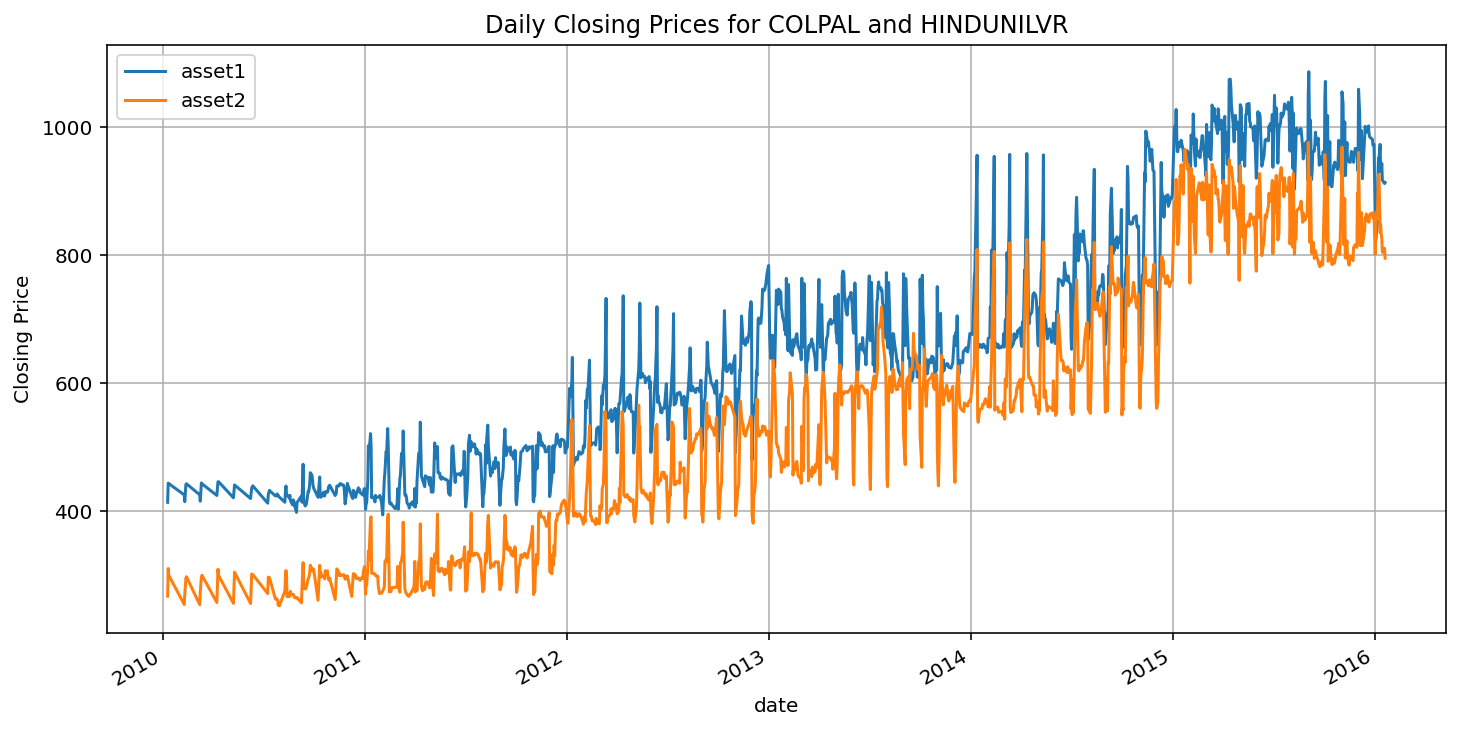

In [24]:
# visualize closing prices
ax = train[['asset1','asset2']].plot(figsize=(12, 6), title = 'Daily Closing Prices for {} and {}'.format(asset1,asset2))
ax.set_ylabel("Closing Price")
ax.grid(True);
plt.savefig('images/chart3', dpi=300) 

In [25]:
# run OLS regression
model=sm.OLS(train.asset2, train.asset1).fit()

FileNotFoundError: ignored

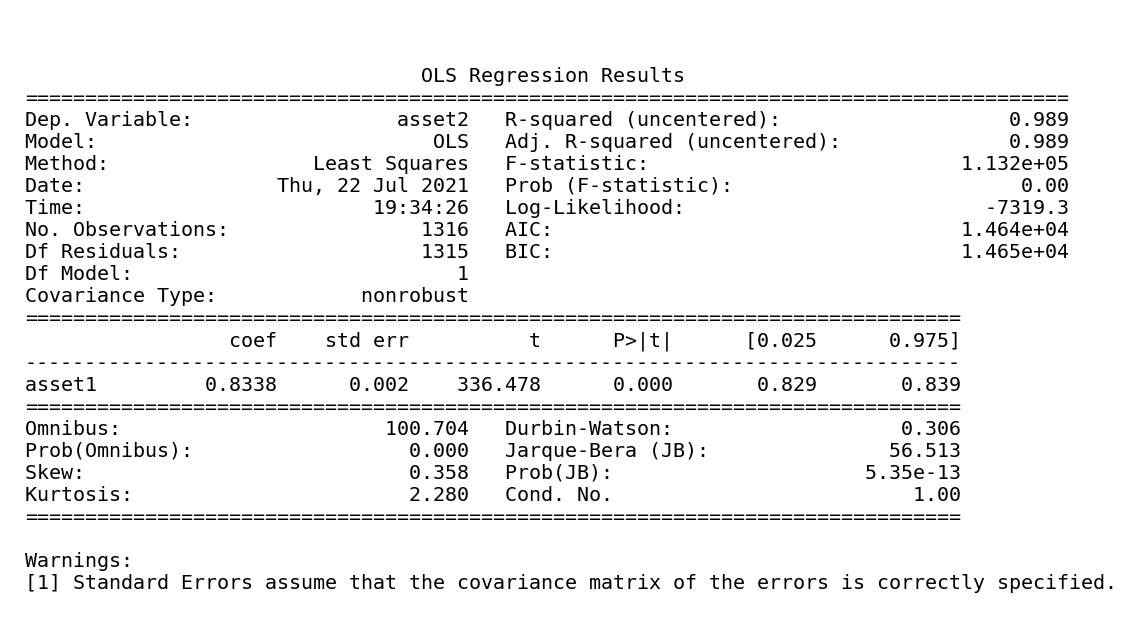

In [26]:
# print regression summary results
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 16}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.7, bottom=0.1)
plt.savefig('images/chart4', dpi=300);

In [47]:
model.params

asset1    0.833772
dtype: float64

In [27]:
print('Hedge Ratio = ', model.params[0])

Hedge Ratio =  0.8337719329978226


In [28]:
# calculate spread
spread = train.asset2 - model.params[0] * train.asset1

FileNotFoundError: ignored

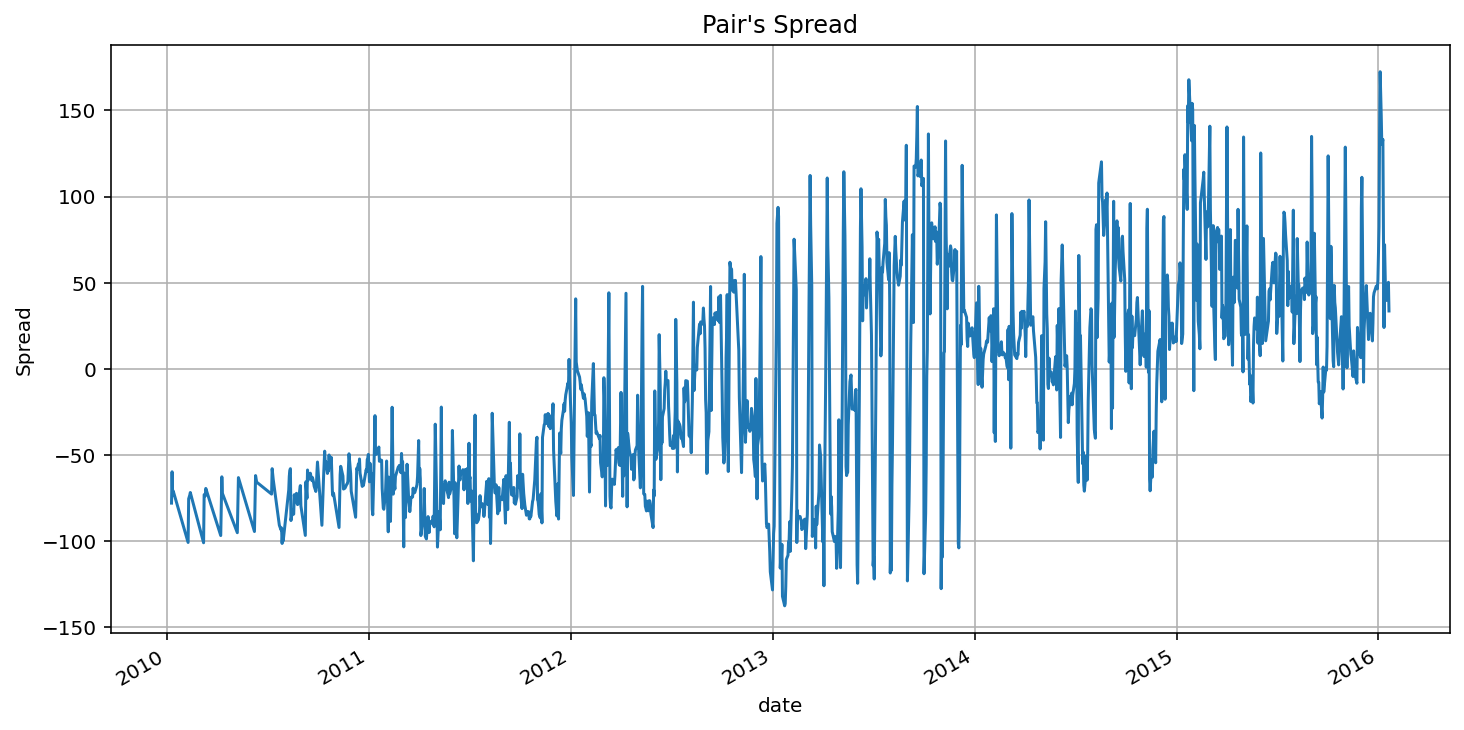

In [29]:
# Plot the spread
ax = spread.plot(figsize=(12, 6), title = "Pair's Spread")
ax.set_ylabel("Spread")
ax.grid(True);
plt.savefig('images/chart5', dpi=300);

In [30]:
# conduct Augmented Dickey-Fuller test
adf = adfuller(spread, maxlag = 1)
print('Critical Value = ', adf[0])

Critical Value =  -9.170679161407012


In [31]:
# probablity critical values
print(adf[4])

{'1%': -3.435336393256612, '5%': -2.863742089354917, '10%': -2.5679424031562683}


### Generate Trading Signals using z-score

In [32]:
# calculate z-score
def zscore(series):
    return (series - series.mean()) / np.std(series)

In [33]:
# create a dataframe for trading signals
signals = pd.DataFrame()
signals['asset1'] = test_close[asset1] 
signals['asset2'] = test_close[asset2]
ratios = signals.asset1 / signals.asset2

In [34]:
# calculate z-score and define upper and lower thresholds
signals['z'] = zscore(ratios)
signals['z upper limit'] = np.mean(signals['z']) + np.std(signals['z'])
signals['z lower limit'] = np.mean(signals['z']) - np.std(signals['z'])

In [35]:
# create signal - short if z-score is greater than upper limit else long
signals['signals1'] = 0
signals['signals1'] = np.select([signals['z'] > \
                                 signals['z upper limit'], signals['z'] < signals['z lower limit']], [-1, 1], default=0)

In [36]:
# we take the first order difference to obtain portfolio position in that stock
signals['positions1'] = signals['signals1'].diff()
signals['signals2'] = -signals['signals1']
signals['positions2'] = signals['signals2'].diff()

In [ ]:
# # visualize z-score and upper and lower thresholds   
# signals['z'].plot(label="z Value")
# plt.title("Z-score Evolution")
# plt.axhline(signals['z'].mean(),color="black")
# plt.axhline(signals['z upper limit'].mean(), color="red", label="Upper Threshold")
# plt.axhline(signals['z lower limit'].mean(), color="green", label="Lower Threshold")
# plt.legend()
# plt.tight_layout()
# plt.savefig('images/chart6', dpi=300);

In [37]:
# verify dataframe head and tail
signals.head(3).append(signals.tail(3))

,asset1,asset2,z,z upper limit,z lower limit,signals1,positions1,signals2,positions2
date,,,,,,,,,
2016-01-21,907.500000,775.599976,2.256689,1.0,-1.0,-1,NaN,1,NaN
2016-01-22,882.450012,771.500000,2.094993,1.0,-1.0,-1,0.0,1,0.0
2016-01-25,865.400024,783.299988,1.854783,1.0,-1.0,-1,0.0,1,0.0
2021-12-04,1559.199951,2462.000000,-1.049503,1.0,-1.0,1,1.0,-1,-1.0
2021-12-05,1529.400024,2328.949951,-0.905464,1.0,-1.0,0,-1.0,0,1.0
2021-12-07,1732.550049,2444.149902,-0.584149,1.0,-1.0,0,0.0,0,0.0


In [ ]:
# # check portfolio position
# signals[signals.signals1 != 0].head(10)

In [ ]:
# signals[signals.positions1 != 0].head().append(signals[signals.positions1 != 0].tail())

In [ ]:
# signals.loc[signals['positions1'] == 1].index
# signals['asset1'][signals['positions1'] == 1].value_counts()

FileNotFoundError: ignored

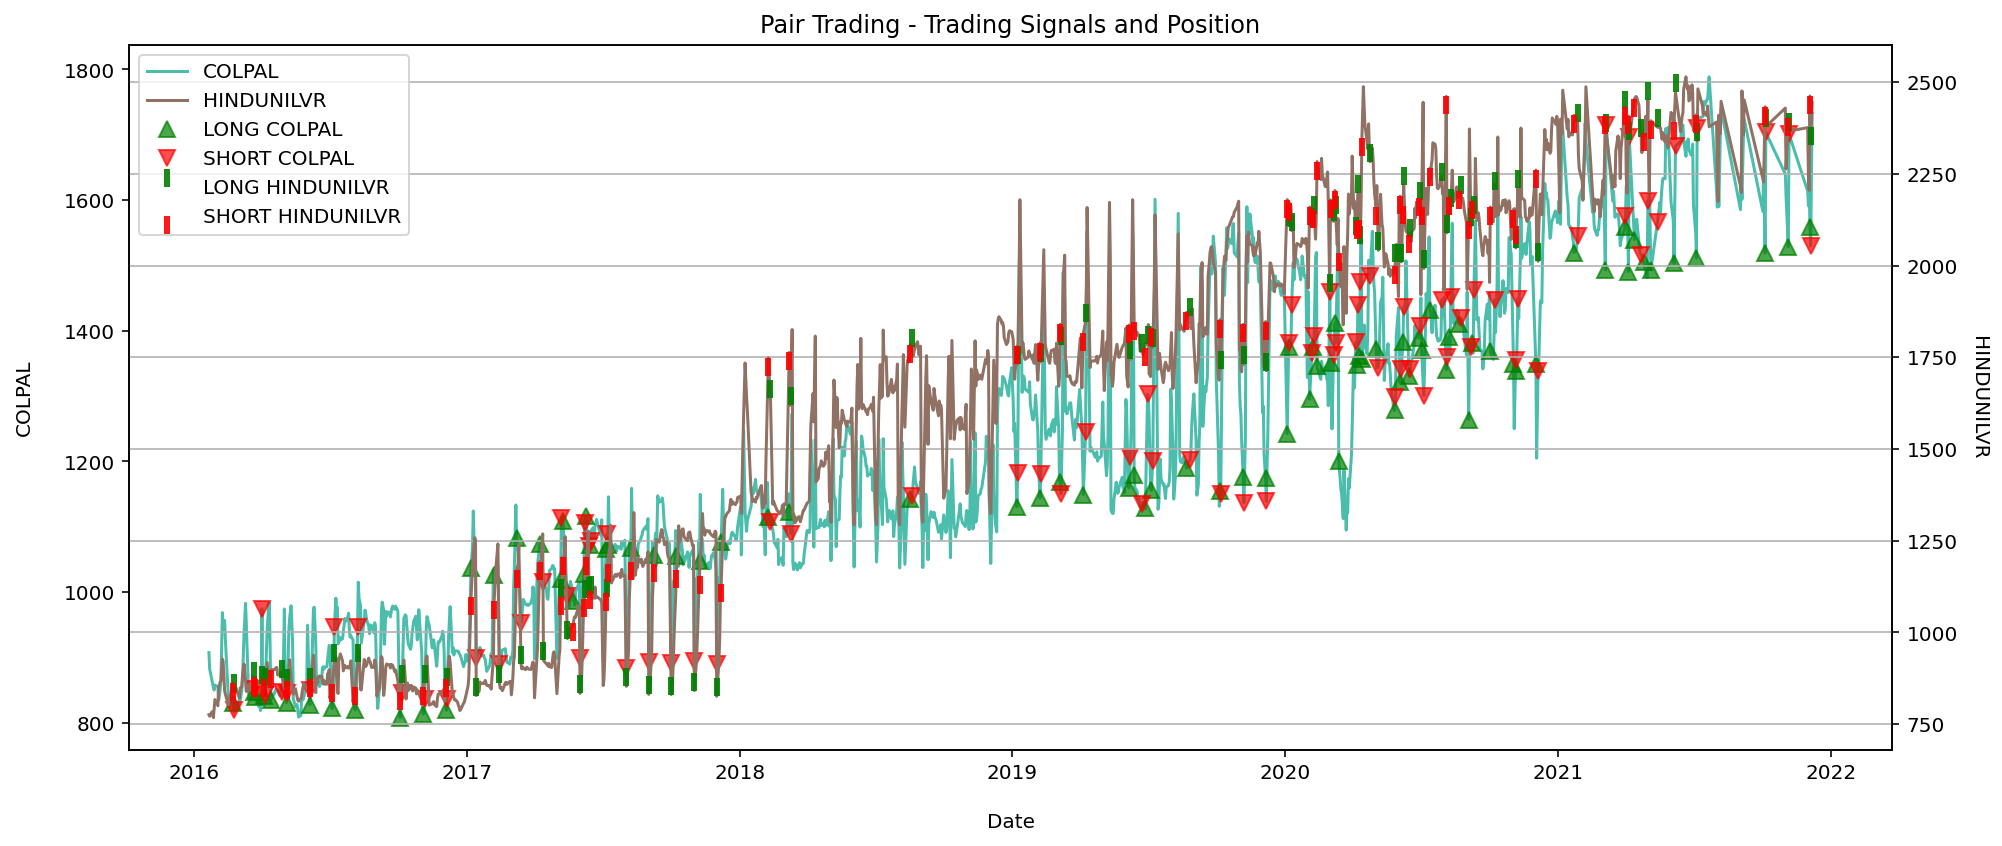

In [38]:
# visualize trading signals and position
fig=plt.figure(figsize=(14,6))
bx = fig.add_subplot(111)   
bx2 = bx.twinx()

#plot two different assets
l1, = bx.plot(signals['asset1'], c='#4abdac')
l2, = bx2.plot(signals['asset2'], c='#907163')

u1, = bx.plot(signals['asset1'][signals['positions1'] == 1], lw=0, marker='^', markersize=8, c='g',alpha=0.7)

d1, = bx.plot(signals['asset1'][signals['positions1'] == -1], lw=0,marker='v',markersize=8, c='r',alpha=0.7)

u2, = bx2.plot(signals['asset2'][signals['positions2'] == 1], lw=0,marker=2,markersize=9, c='g',alpha=0.9, markeredgewidth=3)

d2, = bx2.plot(signals['asset2'][signals['positions2'] == -1], lw=0,marker=3,markersize=9, c='r',alpha=0.9,markeredgewidth=3)

bx.set_ylabel(asset1,)
bx2.set_ylabel(asset2, rotation=270)
bx.yaxis.labelpad=15
bx2.yaxis.labelpad=15
bx.set_xlabel('Date')
bx.xaxis.labelpad=15

plt.legend([l1,l2,u1,d1,u2,d2], [asset1, asset2,'LONG {}'.format(asset1),
           'SHORT {}'.format(asset1),
           'LONG {}'.format(asset2),
           'SHORT {}'.format(asset2)], loc ='best')

plt.title('Pair Trading - Trading Signals and Position')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.savefig('images/chart7', dpi=300);

### Portfolio Profit and Loss Calculation

In [39]:

initial_capital = 100000


positions1 = initial_capital// max(signals['asset1'])
positions2 = initial_capital// max(signals['asset2'])

In [40]:
# since there are two assets, we calculate each asset Pnl separately 
# and in the end we aggregate them into one portfolio
portfolio = pd.DataFrame()
portfolio['asset1'] = signals['asset1']
portfolio['holdings1'] = signals['positions1'].cumsum() * signals['asset1'] * positions1
portfolio['cash1'] = initial_capital - (signals['positions1'] * signals['asset1'] * positions1).cumsum()
portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
portfolio['return1'] = portfolio['total asset1'].pct_change()
portfolio['positions1'] = signals['positions1']

In [ ]:
# portfolio.head().append(portfolio.tail())

In [ ]:
# portfolio[portfolio.positions1 != 0].head()

In [41]:
# pnl for the 2nd asset
portfolio['asset2'] = signals['asset2']
portfolio['holdings2'] = signals['positions2'].cumsum() * signals['asset2'] * positions2
portfolio['cash2'] = initial_capital - (signals['positions2'] * signals['asset2'] * positions2).cumsum()
portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
portfolio['return2'] = portfolio['total asset2'].pct_change()
portfolio['positions2'] = signals['positions2']

In [ ]:
# portfolio.to_csv('data/portfolio.csv')
# portfolio.head().append(portfolio.tail())

In [ ]:
# portfolio[portfolio.positions2 != 0].head()

In [42]:
# total pnl and z-score
portfolio['z'] = signals['z']
portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
portfolio['z upper limit'] = signals['z upper limit']
portfolio['z lower limit'] = signals['z lower limit']
portfolio = portfolio.dropna()

FileNotFoundError: ignored

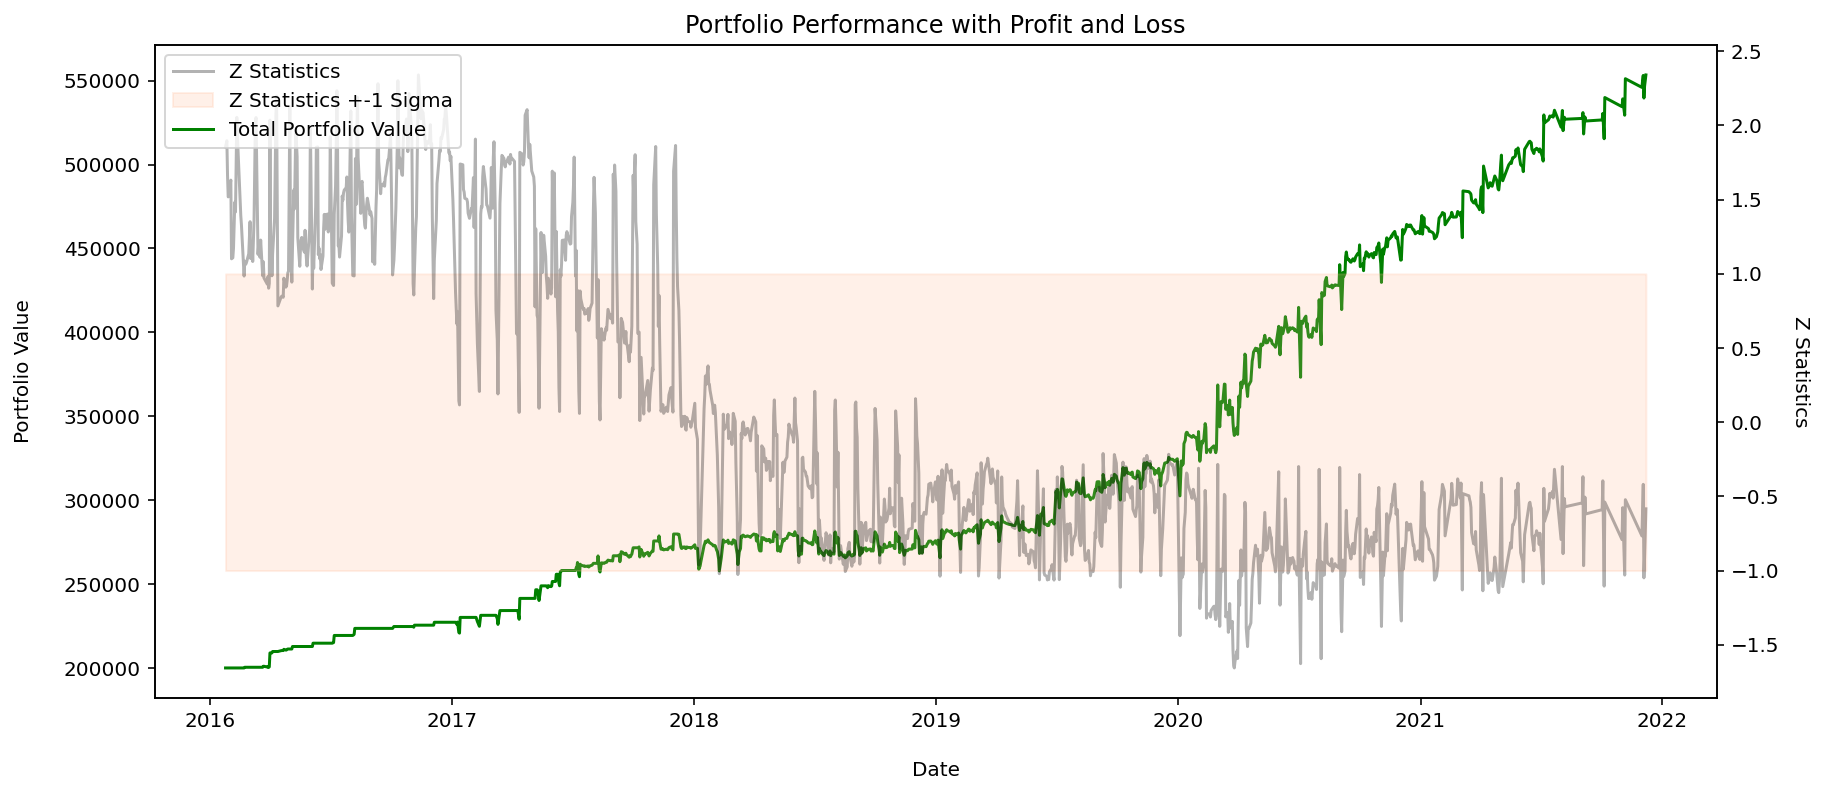

In [43]:
# plot the asset value change of the portfolio and pnl along with z-score
fig = plt.figure(figsize=(14,6),)
ax = fig.add_subplot(111)
ax2 = ax.twinx()

l1, = ax.plot(portfolio['total asset'], c='g')
l2, = ax2.plot(portfolio['z'], c='black', alpha=0.3)

b = ax2.fill_between(portfolio.index,portfolio['z upper limit'],\
                portfolio['z lower limit'], \
                alpha=0.2,color='#ffb48f')

ax.set_ylabel('Portfolio Value')
ax2.set_ylabel('Z Statistics',rotation=270)
ax.yaxis.labelpad=15
ax2.yaxis.labelpad=15
ax.set_xlabel('Date')
ax.xaxis.labelpad=15
plt.title('Portfolio Performance with Profit and Loss')
plt.legend([l2,b,l1],['Z Statistics',
                      'Z Statistics +-1 Sigma',
                      'Total Portfolio Value'],loc='upper left');
plt.savefig('images/chart8', dpi=300);

In [44]:
# calculate CAGR
final_portfolio = portfolio['total asset'].iloc[-1]
delta = (portfolio.index[-1] - portfolio.index[0]).days
print('Number of days = ', delta)

Number of days =  2143


In [45]:
YEAR_DAYS = 365
returns = (final_portfolio/initial_capital) ** (YEAR_DAYS/delta) - 1
print('CAGR = {:.3f}%' .format(returns * 100))

CAGR = 33.832%
